<a href="https://colab.research.google.com/github/jtorom/jtorom/blob/develop/Rocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuraciones

In [1]:
!pip install --upgrade -q gspread


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import gspread
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

def save_to_gsheets(df, sheet_name, worksheet_name='Sheet1'):
    sheet = gc.open(sheet_name)
    worksheet = sheet.worksheet(worksheet_name)
    # convertimos el tipo de las columnas que sean datetime a string
    for column in df.columns[df.dtypes == 'datetime64[ns]']:
        df[column] = df[column].astype(str)
    # reemplazamos valores NaN por strings vacíos
    #worksheet.update([df.columns.values.tolist()] + df.fillna('').values.tolist())
    worksheet.append_rows(df.fillna('').values.tolist())
    print(f'DataFrame escrito en la hoja {sheet_name} / {worksheet_name}.')



import numpy as np
import pandas as pd
import datetime
import pytz
tz = pytz.timezone('America/Santiago')
ct = datetime.datetime.now(tz=tz)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp -rf /content/drive/MyDrive/Palas\ fotos/Fotos\ contorneadas/labelme/*.* /content/drive/MyDrive/Colab\ Notebooks/WorkspaceTesis/data/Train/


In [4]:
!cp -rf /content/drive/MyDrive/Palas\ fotos/Distribución\ de\ Imágenes/Imágenes\ Jonathan\ T./Test/*.* /content/drive/MyDrive/Colab\ Notebooks/WorkspaceTesis/data/Test/

In [5]:
import os
path = '/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/data/Train/'
jpg_count = len([f for f in os.listdir(path) if f.endswith('.jpg')])
print(jpg_count)

213


In [6]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis')
#Descarga de las librerias de Mask RCNN de matterport
#!git clone https://github.com/matterport/Mask_RCNN Version antigua
if not os.path.exists('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/Mask-RCNN'):
  !git clone https://github.com/masc-it/Mask-RCNN.git #version mejorada


In [7]:
folder="rock_data20231223T1907_copy/"
if not os.path.exists("/content/logs/"+folder):
  os.makedirs("/content/logs")
  os.chdir("/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/logs")
  os.system("cp -rf "+ folder +" /content/logs/"+folder)


In [8]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis')
%cd Mask-RCNN
#!pip list
!pip3 install -r requirements.txt
!python3 setup.py install

/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/Mask-RCNN
ERROR: Could not find a version that satisfies the requirement numpy==2.19.2 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5, 1.20.0, 1.20.1, 1.20.2, 1.20.3, 1.21.0, 1.21.1, 1.21.2, 1.21.3, 1.21.4, 1.21.5, 1.21.6, 1.22.0, 1.22.1, 1.22.2, 1.22.3, 1.22.4, 1.23.0rc1, 1.23.0rc2, 1.23.0rc3, 1.23.0, 1.23.1, 1.23.2, 1.23.3, 1.23.4, 1.23.5, 1.24.0rc1, 1.24.0rc2, 1.24.0, 1.24.1, 1.24.2, 1.24.3, 1.24.4, 1.25.0rc1, 1.25.0, 1.25.1, 1.25.2, 1.26.0b1, 1.

In [9]:
#Descarga de la matriz de pesos COCO.h5
if not os.path.exists('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/Mask-RCNN/cocoapi'):
  !git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!make
%cd ../../


/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/Mask-RCNN/cocoapi/PythonAPI
python setup.py build_ext --inplace
running build_ext
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-cpython-310
creating build/temp.linux-x86_64-cpython-310/pycocotools
x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -I/usr/local/lib/python3.10/dist-packages/numpy/core/include -I../common -I/usr/include/python3.10 -c ../common/maskApi.c -o build/temp.linux-x86_64-cpython-310/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:7: warning: this ‘for’ clause does not guard... []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wmisleading-indentation-Wmisleading-indentation]8;;]
   46 |       for( k=0; k<R[i].cnts[j]; k++ ) *(M++)=v; v=

In [10]:
import tensorflow as tf
#gpus = tf.config.experimental.list_physical_devices('GPU')
#if gpus:
#  try:
#    for gpu in gpus:
#      tf.config.experimental.set_memory_growth(gpu, True)
#  except RuntimeError as e:
#    print(e)


#from tensorflow.python.client import device_lib
#with tf.device('/device:GPU:0'):
#  print('Hola GPU')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=13312)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

DEVICE = "/gpu:0"

1 Physical GPUs, 1 Logical GPUs


In [11]:
import tensorflow as tf
import skimage as ski
print(ski.__version__)

with tf.device('/device:GPU:0'):
  if not (ski.__version__=="0.16.2"):
    !pip uninstall --yes scikit-image
    if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/ski/scikit-image-0.16.2.tar.gz"):
      !pip download --destination-directory "/content/drive/MyDrive/Colab\ Notebooks/WorkspaceTesis/ski/" scikit-image==0.16.2
    #!pip install scikit-image==0.16.2
    #!pip install --no-index --find-links "/content/drive/MyDrive/Colab\ Notebooks/WorkspaceTesis/ski/" scikit-image
    !pip install --find-links "/content/drive/MyDrive/Colab\ Notebooks/WorkspaceTesis/ski/" scikit-image==0.16.2
    os.kill(os.getpid(), 9)


0.16.2


In [12]:

import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import cv2
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import imgaug
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Dense,Flatten , Conv2D , MaxPooling2D , Dropout
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import datetime

In [13]:
ROOT_DIR = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis')

sys.path.append(ROOT_DIR)

In [14]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/Mask-RCNN/')
from mrcnn.config import Config
from mrcnn import utils
os.chdir('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/Mask-RCNN/mrcnn/')
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
%matplotlib inline

In [15]:
MODEL_DIR = os.path.abspath('/content/logs')

if not os.path.exists(MODEL_DIR):
  os.mkdir(MODEL_DIR)

COCO_MODEL_PATH = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/logs/mask_rcnn_coco.h5')


In [16]:

if os.path.exists(os.path.join(COCO_MODEL_PATH)):
  print("coco model exist")
%cd /content/drive/MyDrive/Colab Notebooks/WorkspaceTesis
#!ls

coco model exist
/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis


In [17]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
DATA_DIR = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/data/')

In [18]:

os.chdir('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/data/')
DATASET_TRAIN_DIR=os.path.join(DATA_DIR,'Train')
DATASET_VAL_DIR=os.path.join(DATA_DIR,'Validation')
DATASET_TEST_DIR=os.path.join(DATA_DIR,'Test')


config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)



In [19]:
path='/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/data/Train'
imageSize = [350, 536,3]
sizeEpochSteps = jpg_count ##mismo valor que la cantidad de img en train

def ajustarTamano(path):
  os.chdir(path)
  for i,f in enumerate(os.listdir('.')):

    file_name, file_extension = os.path.splitext(f)
    #print(file_extension)
    if os.path.isfile(f) and file_extension=='.jpg':
      try:

        image_path_jpg = f
        print(image_path_jpg)
        img = tf.io.read_file(image_path_jpg)
        #print(img.get_shape().as_list()) # []
        img = tf.image.decode_jpeg(img)
        #print(img.get_shape().as_list())
        img_resized = tf.image.resize(img, [imageSize[0], imageSize[1]])
        img_resized = img_resized.eval(session=session)
        #print(type(img_resized))
        img_resized_tensor = tf.reshape(img_resized, [imageSize[0], imageSize[1]] )
        img_resized = img_resized_tensor.eval(session=session)
        cv2.imwrite(f, img_resized)
      except:
        print("Error en :" , f)


#path='/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/data/Train'
#ajustarTamano(path)
#path='/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/data/Test'
#ajustarTamano(path)
#path='/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/data/Validation'
#ajustarTamano(path)

In [20]:
#os.chdir('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/Mask-RCNN/')
#from config_rocks import Rocks
class Rocks(Config):

  NAME ="rock_Data"
  IMAGES_PER_GPU = 1
  GPU_COUNT = 1
  NUM_CLASSES = 2 #Background + rock"
  STEPS_PER_EPOCH = sizeEpochSteps # Se pone el mismo n mero de imagenes que hay en la carpeta Train
  DETECTION_MIN_CONFIDENCE = 0.55
  # MiniMask
  USE_MINI_MASK = False
  IMAGE_SHAPE = imageSize
  LEARNING_RATE=0.00556
  DETECTION_MAX_INSTANCES=300
  VALIDATION_STEPS = 100

In [21]:
config = Rocks()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        300
DETECTION_MIN_CONFIDENCE       0.55
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.00556
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE       

In [22]:
from PIL import Image,ImageDraw
axis_Width = 15

In [23]:

class RocksDataset(utils.Dataset):

  def load_dataset(self, dataset_dir):

    self.add_class('dataset', 1, 'rock')

    for i, filename in enumerate(os.listdir(dataset_dir)):
      annotation_file = os.path.join(dataset_dir , filename.replace('.jpg', '.json'))
      if '.jpg' in filename and os.path.isfile(annotation_file):
        self.add_image('dataset',image_id=i,path=os.path.join(dataset_dir , filename),annotation=annotation_file)

  def extract_masks(self, filename):
    json_file = os.path.join(filename) #Devuelve el nombre del fichero con string->’.
    with open(json_file) as f:
      img_anns = json.load(f)
    n_masks = 0
    for anno in img_anns['shapes']:
      if anno['label']=='rock':
        n_masks+=1#
    masks = np.zeros([img_anns['imageHeight'], img_anns['imageWidth'], n_masks], dtype='uint8')
    classes = []#
    i=0
    for anno in img_anns['shapes']:
      if anno['label']=='rock':
        mask = np.zeros([img_anns['imageHeight'], img_anns['imageWidth']], dtype=np.uint8)
        cv2.fillPoly(mask, np.array([anno['points']], dtype=np.int32), 1)
        masks[:, :, i] = mask
        classes.append(self.class_names.index(anno['label']))
        i+=1
    return masks , classes


  def load_mask(self, image_id):
    info = self.image_info[image_id]
    path = info['annotation']
    masks, classes = self.extract_masks(path)
    return masks, np.asarray(classes, dtype='int32')

  def image_reference(self, image_id):
    info = self.image_info[image_id]
    return info['path']




In [24]:
dataset_train = RocksDataset()
dataset_train.load_dataset(DATASET_TRAIN_DIR)
dataset_train.prepare()


In [25]:

lendataset_train=len(dataset_train.image_ids)
print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
  print("{:3}. {:50}".format(i, info['name']))


Image Count: 213
Class Count: 2
  0. BG                                                
  1. rock                                              


In [26]:

dataset_val = RocksDataset()
dataset_val.load_dataset(DATASET_VAL_DIR)
dataset_val.prepare()

In [27]:

lendataset_val=len(dataset_val.image_ids)
print("Image Count: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
  print("{:3}. {:50}".format(i, info['name']))

Image Count: 56
Class Count: 2
  0. BG                                                
  1. rock                                              


In [28]:

dataset_test = RocksDataset()
dataset_test.load_dataset(DATASET_TEST_DIR)
dataset_test.prepare()
print('Test: %d images' % len(dataset_test.image_ids))

Test: 53 images


In [29]:

lendataset_test=len(dataset_test.image_ids)
print("Image Count: {}".format(len(dataset_test.image_ids)))
print("Class Count: {}".format(dataset_test.num_classes))
for i, info in enumerate(dataset_test.class_info):
  print("{:3}. {:50}".format(i, info['name']))


Image Count: 53
Class Count: 2
  0. BG                                                
  1. rock                                              


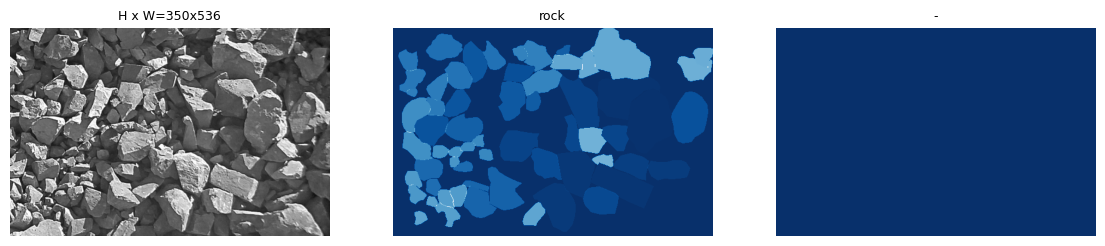

In [30]:

image_ids=np.random.choice(dataset_train.image_ids,1)
for image_id in image_ids:
  image = dataset_train.load_image(image_id)
  mask, class_ids = dataset_train.load_mask(image_id)
  visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names,2)



In [31]:
import keras
print(keras.__version__)
#keras.src.engine.functional.Functional
#2.15.0

2.15.0


In [32]:
epochsHead=10
epochsLast=20

In [33]:
def weightsTrain(init):
  model = modellib.MaskRCNN(mode="training", config=config , model_dir=MODEL_DIR)
  model.find_last()
  init_with = init
  #init_with="last" "coco"
  if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
  elif init_with == "coco":
    #model.load_weights(COCO_MODEL_PATH, by_name=True,exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
    model.load_weights(COCO_MODEL_PATH, by_name=True,exclude=["mrcnn_class_logits","mrcnn_bbox_fc","mrcnn_mask"]  )
  elif init_with == "last":
    model.load_weights(model.find_last(), by_name=True)
    #!pip list

  dataResult= {
    "Fecha": ct.isoformat(),
    "FechaInicio": ct.isoformat(),
    "FechaFin": "",
    "CountTrain" : [lendataset_train],
    "CountTest" : [lendataset_test],
    "CountVal" : [lendataset_val],
    "EphocsHead" : [epochsHead],
    "EphocsLast" : [epochsLast],
    "folderName" : "",
    "folderPesosAnteriores":folder,
    "Confidence" : [Rocks.DETECTION_MIN_CONFIDENCE],
    "LearningRate": [Rocks.LEARNING_RATE],
    "Precision" : [0],
    "Recall" : [0],
    "F1" : [0],
    "Accuracy" : [0],
    "init_with": init_with,
    "epochNum": 0,
    "type": "Train"
  }

  df = pd.DataFrame(dataResult)
  save_to_gsheets(df, 'ResultadosColab', worksheet_name='Sheet1')
  return model,dataResult

model,dataResult=weightsTrain("last")


self.model_dir: /content/logs
Dir_names: ['rock_data20231226T1803', 'rock_data20231223T1907_copy']
self.model_dir: /content/logs
Dir_names: ['rock_data20231226T1803', 'rock_data20231223T1907_copy']
Re-starting from epoch 5
DataFrame escrito en la hoja ResultadosColab / Sheet1.


# Entrenamiento

In [34]:
Rock_augmentation = imgaug.augmenters.Sometimes(0.99,[imgaug.augmenters.geometric.Affine(rotate=(-360,360))])


In [35]:
def get_ax(rows=1, cols=1, size=10):
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax



/usr/local/lib/python3.10/dist-packages/imgaug/augmenters/base.py:49: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (1024, 1024, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  ia.warn(
/usr/local/lib/python3.10/dist-packages/imgaug/augmenters/base.py:49: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (1024, 1024, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your in

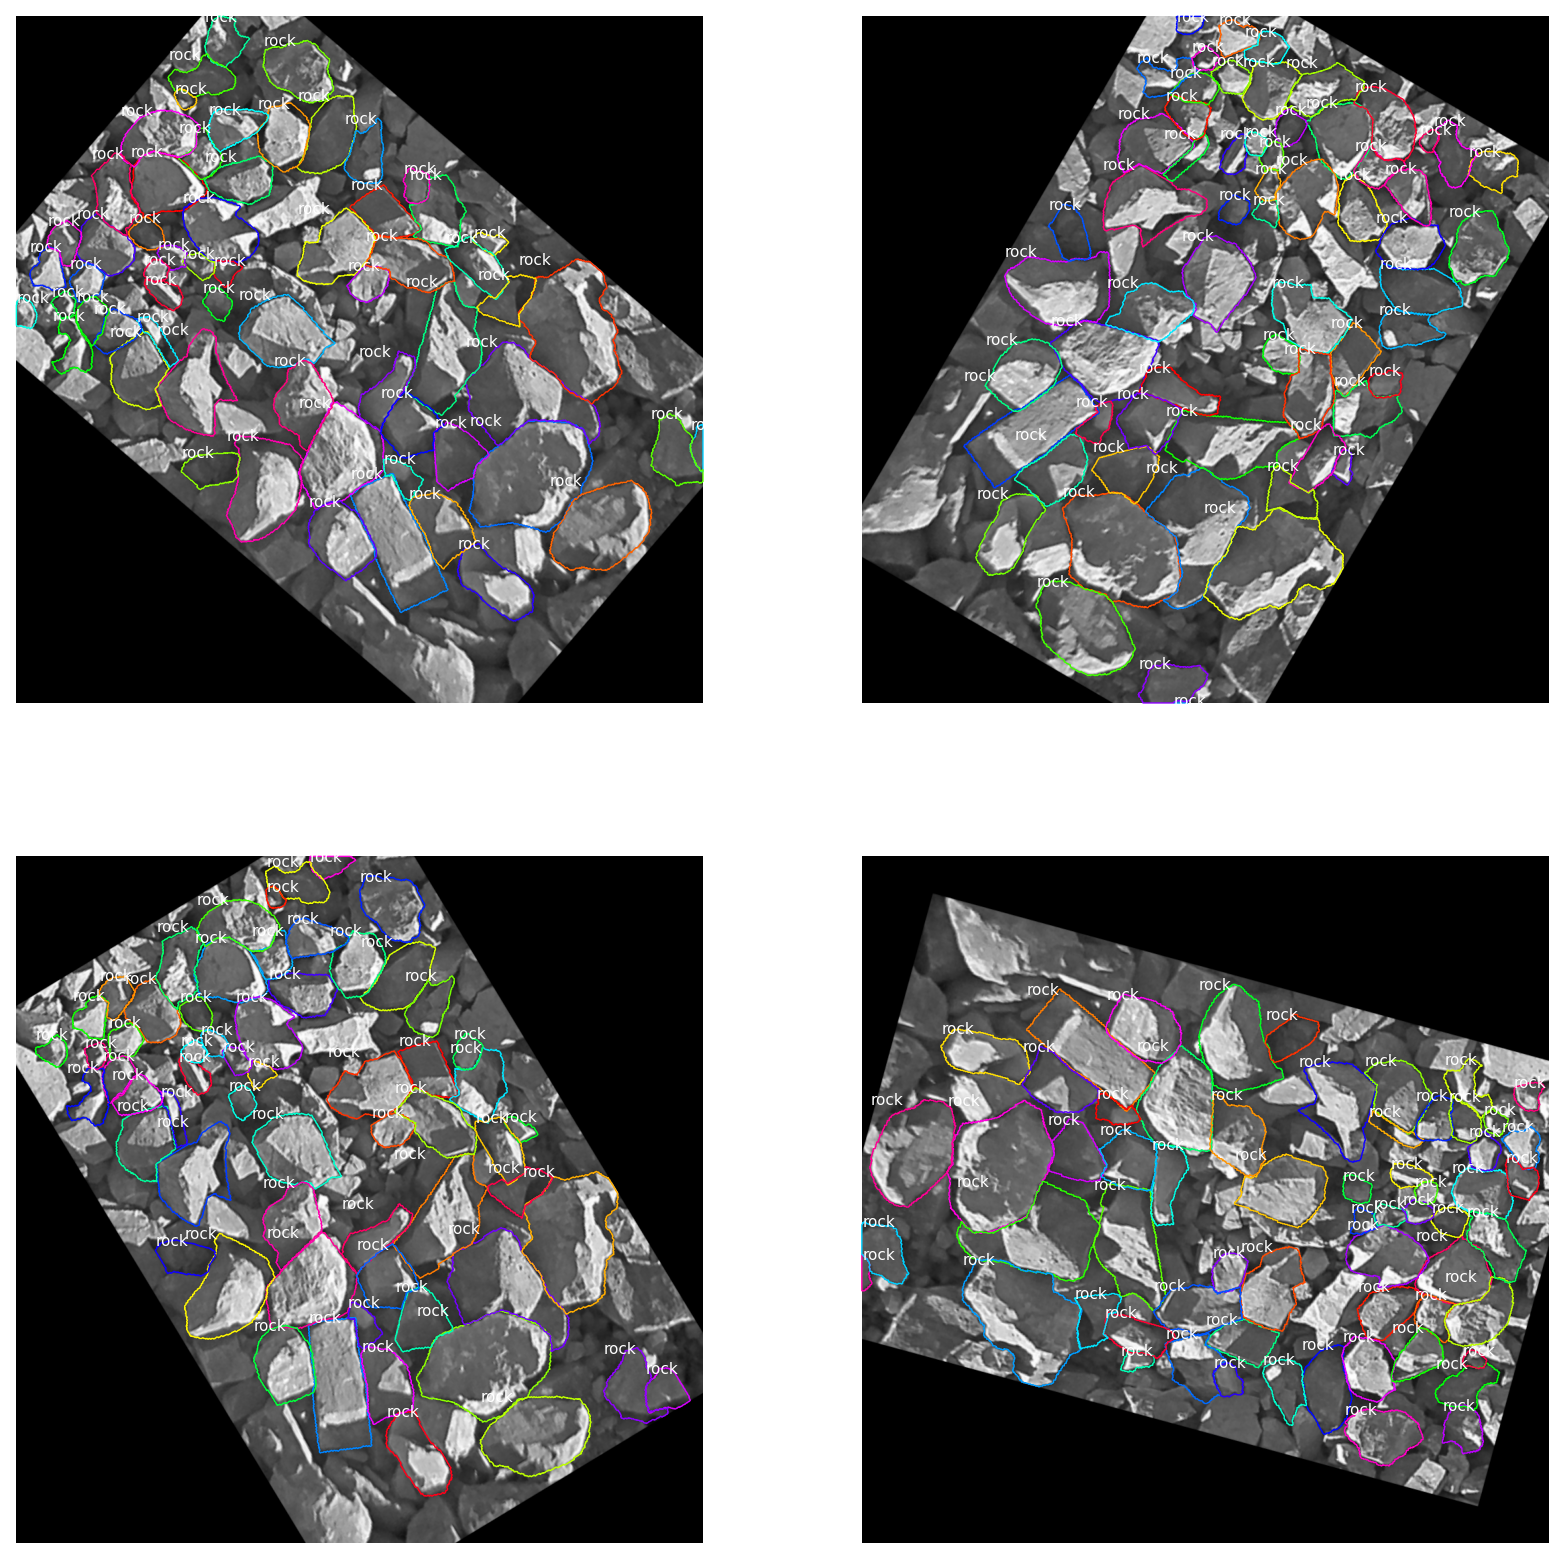

In [36]:
limit = 4
ax = get_ax(rows=2, cols=limit//2)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset_train, config, image_id, augmentation=Rock_augmentation)
    visualize.display_instances(image, bbox, mask, class_ids,
                                dataset_train.class_names, ax=ax[i//2, i % 2],
                                show_mask=False, show_bbox=False)

In [37]:
def copyFilesLogs(newFolderLog):
  os.chdir("/content/logs/")
  os.system("cp -rf ./"+ newFolderLog +"/ /content/drive/MyDrive/Colab\ Notebooks/WorkspaceTesis/logs/")

In [38]:
import warnings
warnings.filterwarnings('ignore')

def trainHead(model):
  with tf.device('/device:GPU:0'):
    %time
    model.train(
          dataset_train
        , dataset_val
        , learning_rate=config.LEARNING_RATE
        , epochs=epochsHead
        , layers='heads'
        , augmentation = Rock_augmentation
        )
  history = model.keras_model.history.history
  copyFilesLogs(model.checkpoint_path.split('/')[3])
  return model,history

model,history=trainHead(model)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs

Starting at epoch 5. LR=0.00556

Checkpoint Path: /content/logs/rock_data20231226T1803/mask_rcnn_rock_data_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrc

In [39]:
def checkFileh5(epochs,stepTrain,model):
  numFile=("0000"+str(epochs))[-4:]
  pathHeadFile="/content/logs/"+newFolderLog+"/mask_rcnn_rock_data_"+numFile+".h5"
  print(pathHeadFile)
  while not (os.path.exists(pathHeadFile)):
    print("archivo "+numFile+" no existe")
    if(stepTrain=="head"):
      model,dataResult=weightsTrain("last")
      model,history=trainHead(model)
    if(stepTrain=="last"):
      model,dataResult=weightsTrain("last")
      model,new_history=trainLast(model)
  return model

newFolderLog=model.checkpoint_path.split('/')[3]
model=checkFileh5(epochsHead,"head",model)

/content/logs/rock_data20231226T1803/mask_rcnn_rock_data_0010.h5


In [40]:
tz = pytz.timezone('America/Santiago')
ct = datetime.datetime.now(tz=tz)


dataResult.update({"FechaInicio": ct.isoformat()})
dataResult.update({"epochNum": model.epoch})



print(dataResult)
df = pd.DataFrame(dataResult)
save_to_gsheets(df, 'ResultadosColab', worksheet_name='Sheet1')

{'Fecha': '2023-12-26T19:18:16.130046-03:00', 'FechaInicio': '2023-12-26T20:17:11.401553-03:00', 'FechaFin': '', 'CountTrain': [213], 'CountTest': [53], 'CountVal': [56], 'EphocsHead': [10], 'EphocsLast': [20], 'folderName': '', 'folderPesosAnteriores': 'rock_data20231223T1907_copy/', 'Confidence': [0.55], 'LearningRate': [0.00556], 'Precision': [0], 'Recall': [0], 'F1': [0], 'Accuracy': [0], 'init_with': 'last', 'epochNum': 10, 'type': 'Train'}
DataFrame escrito en la hoja ResultadosColab / Sheet1.


In [41]:
def trainLast(model):
  with tf.device('/device:GPU:0'):
    %time
    model.train(dataset_train , dataset_val , learning_rate=config.LEARNING_RATE / 10,epochs=epochsLast, layers="all")
    new_history = model.keras_model.history.history
    copyFilesLogs(model.checkpoint_path.split('/')[3])
  return model,new_history

model,new_history=trainLast(model)
model=checkFileh5(epochsLast,"last",model)

CPU times: user 12 µs, sys: 10 µs, total: 22 µs
Wall time: 48.9 µs

Starting at epoch 10. LR=0.000556

Checkpoint Path: /content/logs/rock_data20231226T1803/mask_rcnn_rock_data_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a

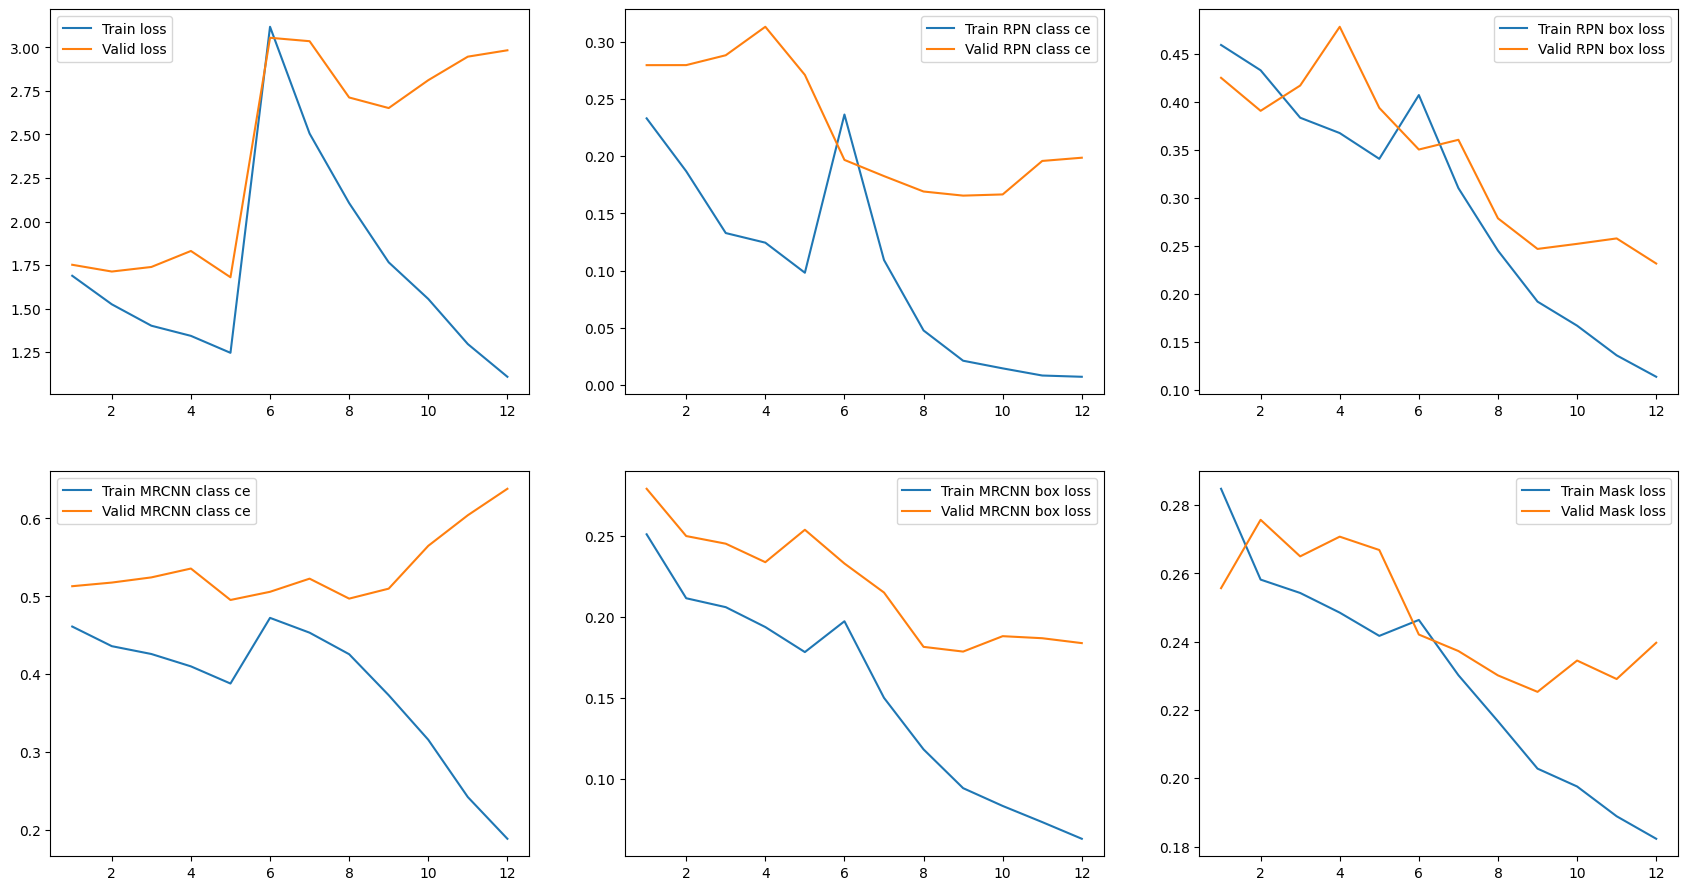

In [42]:
save_dir = "/content/output"
df = pd.DataFrame(history)
df2 = pd.DataFrame(new_history)
if not os.path.exists(save_dir):
  os.makedirs(save_dir)
df.to_json(os.path.join(save_dir ,"history.json"))
df2.to_json(os.path.join(save_dir ,"new_history.json"))



if(len(history)>0):
  for k in new_history: history[k] = history[k] + new_history[k]
  epochs = range(1, len(history['loss'])+1)
else:
  history=new_history.copy()
  epochs = range(1, len(history['loss'])+1)

pd.DataFrame(history, index=epochs)

plt.figure(figsize=(21,11))

plt.subplot(231)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(232)
plt.plot(epochs, history["rpn_class_loss"], label="Train RPN class ce")
plt.plot(epochs, history["val_rpn_class_loss"], label="Valid RPN class ce")
plt.legend()
plt.subplot(233)
plt.plot(epochs, history["rpn_bbox_loss"], label="Train RPN box loss")
plt.plot(epochs, history["val_rpn_bbox_loss"], label="Valid RPN box loss")
plt.legend()
plt.subplot(234)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train MRCNN class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid MRCNN class ce")
plt.legend()
plt.subplot(235)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train MRCNN box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid MRCNN box loss")
plt.legend()
plt.subplot(236)
plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
plt.legend()

plt.show()


In [43]:
tz = pytz.timezone('America/Santiago')
ct = datetime.datetime.now(tz=tz)


dataResult.update({"FechaInicio": ct.isoformat()})
dataResult.update({"epochNum": model.epoch})

print(dataResult)
df = pd.DataFrame(dataResult)
save_to_gsheets(df, 'ResultadosColab', worksheet_name='Sheet1')

{'Fecha': '2023-12-26T19:18:16.130046-03:00', 'FechaInicio': '2023-12-27T00:00:25.168614-03:00', 'FechaFin': '', 'CountTrain': [213], 'CountTest': [53], 'CountVal': [56], 'EphocsHead': [10], 'EphocsLast': [20], 'folderName': '', 'folderPesosAnteriores': 'rock_data20231223T1907_copy/', 'Confidence': [0.55], 'LearningRate': [0.00556], 'Precision': [0], 'Recall': [0], 'F1': [0], 'Accuracy': [0], 'init_with': 'last', 'epochNum': 20, 'type': 'Train'}
DataFrame escrito en la hoja ResultadosColab / Sheet1.


In [44]:
import os

newFolderLog="rock_data20231223T1907"


copyFilesLogs(newFolderLog)




In [45]:
dataResult.update({"folderName": newFolderLog})

In [46]:
tz = pytz.timezone('America/Santiago')
ct = datetime.datetime.now(tz=tz)

dataResult.update({"FechaFin": ct.isoformat()})


print(dataResult)
df = pd.DataFrame(dataResult)
save_to_gsheets(df, 'ResultadosColab', worksheet_name='Sheet1')

{'Fecha': '2023-12-26T19:18:16.130046-03:00', 'FechaInicio': '2023-12-27T00:00:25.168614-03:00', 'FechaFin': '2023-12-27T00:00:28.078085-03:00', 'CountTrain': [213], 'CountTest': [53], 'CountVal': [56], 'EphocsHead': [10], 'EphocsLast': [20], 'folderName': 'rock_data20231223T1907', 'folderPesosAnteriores': 'rock_data20231223T1907_copy/', 'Confidence': [0.55], 'LearningRate': [0.00556], 'Precision': [0], 'Recall': [0], 'F1': [0], 'Accuracy': [0], 'init_with': 'last', 'epochNum': 20, 'type': 'Train'}
DataFrame escrito en la hoja ResultadosColab / Sheet1.


In [47]:
!pip freeze > /content/requirements.txt